# Подготовка сессии

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import fiona
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

import json

import numpy as np
import torch
import random

# Посмотрим на картинки из датасета

def set_seed(seed: int = 3407):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    
    np.random.seed(seed)
    random.seed(seed)
    
set_seed()

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

Found 649 .png files with assosiated .geojson annotations
Found 8 .geojson without images: 
../data/train_dataset/72.png
../data/train_dataset/113.png
../data/train_dataset/393.png
../data/train_dataset/202.png
../data/train_dataset/523.png
../data/train_dataset/688.png
../data/train_dataset/248.png
../data/train_dataset/527.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Разбиение на train/test : 486/163


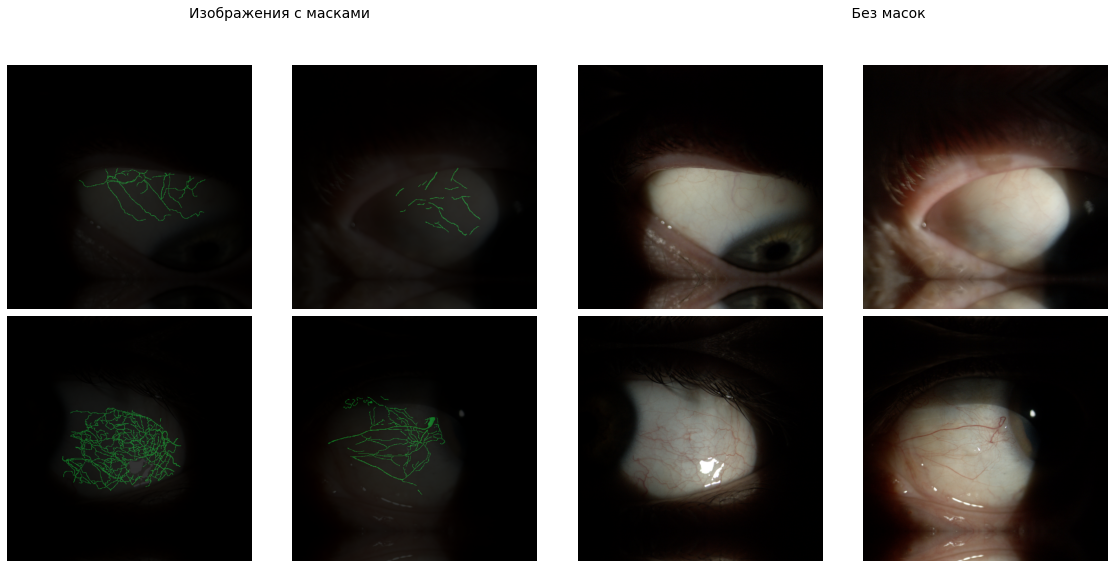

In [20]:
import sys
sys.path.append('../')

from source.dataset import EyeDataset, DatasetPart
from source.plots import plot_dataset

# Задаем преобразование изображений
size = 1024
input_size = 640
train_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              A.Resize(input_size,input_size),
              A.HorizontalFlip(),
              A.VerticalFlip(),
              ToTensorV2(transpose_mask=True),
              ]
eval_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              A.Resize(input_size,input_size),
              ToTensorV2(transpose_mask=True)]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}

# Инициализируем датасет
train_data_dir = '../data/train_dataset/'
test_data_dir = '../data/test_dataset/'
dataset = EyeDataset(train_data_dir)

# Проверим состояние загруженного датасета
# for msg in dataset.make_report():
#   print(msg)
  
plot_dataset(dataset, transforms['test'])

# разделим датасет на тренировочный и валидационный, чтобы смотреть на качество
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25)

print(f"Разбиение на train/test : {len(train_indices)}/{len(test_indices)}")
# Разбиваем объект датасета на тренировачный и валидационный
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])

train_loader = torch.utils.data.DataLoader(train_dataset, 6,
                                   num_workers=4,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 6,
                                   num_workers=8,
                                   shuffle=True, drop_last=True)


## Вспомогательные функции

In [21]:
from source.plots import plot_history
from source.trainer import UnetTrainer
from source.metrics import make_metrics, make_criterion

In [23]:
import pytorch_lightning as ptl

In [ ]:

trainer = ptl.Trainer()

## Модель

In [22]:
# Подргружаем модель и задаём функцию потерь
torch.cuda.empty_cache()
model = smp.Unet('resnet50', activation='logsoftmax', classes=2).cuda()

criterion = make_criterion()
metrics = make_metrics()
lr = 1e-4
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr)
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=metrics)
summary = trainer.fit(train_loader, epochs, val_loader=valid_loader)

Stop iteration
Stop iteration


KeyboardInterrupt: 

## Посмотрим метрики обученной модели на валидационном датасете

In [ ]:
summary

In [5]:
summary

{'loss_train': array([0.86922937, 0.67716008, 0.55136617, 0.48883522, 0.46426608,
        0.44124394, 0.41770924, 0.39901211, 0.38148609, 0.37549126]),
 'exp_dice_train': array([0.13077063, 0.32283993, 0.44863383, 0.51116477, 0.53573391,
        0.55875606, 0.58229076, 0.60098789, 0.61851389, 0.62450874]),
 'accuracy_train': array([0.07323339, 0.22025378, 0.36468423, 0.45037375, 0.49463713,
        0.52265391, 0.5559866 , 0.58405002, 0.59719169, 0.61150784]),
 'recall_train': array([0.7378933 , 0.67124209, 0.62079974, 0.60877796, 0.6097036 ,
        0.62282712, 0.63554003, 0.64595959, 0.6582749 , 0.66058607]),
 'loss_test': array([0.79103299, 0.62143769, 0.5524012 , 0.52887723, 0.52545836,
        0.5200963 , 0.51827214, 0.50641087, 0.54441212, 0.51042173]),
 'exp_dice_test': array([0.20896701, 0.37856232, 0.4475988 , 0.47112277, 0.47454164,
        0.4799037 , 0.48172785, 0.49358912, 0.45558787, 0.48957825]),
 'accuracy_test': array([0.12781064, 0.28130969, 0.39937091, 0.4124167 , 0.3

In [73]:
summary

{'loss_train': array([0.81413044, 0.46366261, 0.43079784, 0.4207865 , 0.41241629,
        0.40399719, 0.39176009, 0.38550393, 0.37951428, 0.37095309]),
 'exp_dice_train': array([0.18586956, 0.53633739, 0.56920216, 0.5792135 , 0.58758371,
        0.59600281, 0.60823991, 0.61449607, 0.62048573, 0.62904691]),
 'accuracy_train': array([0.13554185, 0.53329319, 0.5817984 , 0.60170306, 0.61013715,
        0.61947931, 0.62724126, 0.63757744, 0.64221865, 0.64834678]),
 'recall_train': array([0.86069327, 0.64686551, 0.65808048, 0.65515419, 0.66358568,
        0.665882  , 0.67661318, 0.67827905, 0.68023228, 0.68743218]),
 'loss_test': array([0.56545507, 0.50461006, 0.4910918 , 0.46070983, 0.4704889 ,
        0.4537673 , 0.4652566 , 0.45755774, 0.46698436, 0.46185142]),
 'exp_dice_test': array([0.43454494, 0.49538994, 0.5089082 , 0.53929017, 0.5295111 ,
        0.54623271, 0.5347434 , 0.54244226, 0.53301563, 0.53814858]),
 'accuracy_test': array([0.4609647 , 0.4299728 , 0.65770603, 0.61204974, 0.6

In [7]:
summary

{'loss_train': array([0.60980364, 0.44765319, 0.43025292, 0.41776665, 0.40546184,
        0.39609503, 0.38631059, 0.37986887, 0.36737302, 0.36271663]),
 'exp_dice_train': array([0.39019636, 0.55234681, 0.56974708, 0.58223335, 0.59453816,
        0.60390497, 0.61368941, 0.62013113, 0.63262699, 0.63728337]),
 'accuracy_train': array([2.13316284e+00, 1.38562059e+01, 4.12835110e+01, 4.96108515e+01,
        1.06158843e+02, 8.89758021e+01, 2.10654536e+02, 2.01655175e+00,
        1.72827165e+03, 3.40515360e+04]),
 'recall_train': array([0.67997813, 0.64645925, 0.65131305, 0.65836893, 0.66242302,
        0.6704449 , 0.67828049, 0.67865114, 0.68497311, 0.68484545]),
 'loss_test': array([0.49667367, 0.47772593, 0.47981774, 0.46956167, 0.45521852,
        0.47568898, 0.46132137, 0.46363184, 0.48755409, 0.46900726]),
 'exp_dice_test': array([0.50332632, 0.52227407, 0.52018226, 0.53043832, 0.54478148,
        0.52431102, 0.53867864, 0.53636816, 0.51244592, 0.53099273]),
 'accuracy_test': array([  2

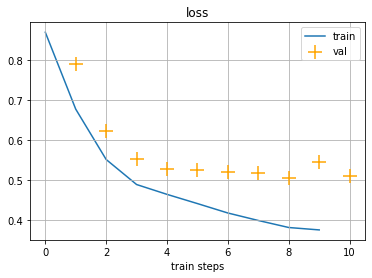

In [6]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

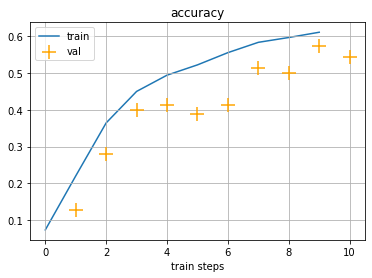

In [7]:
# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")

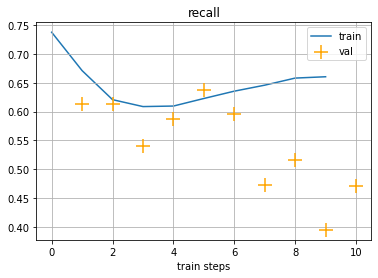

In [8]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

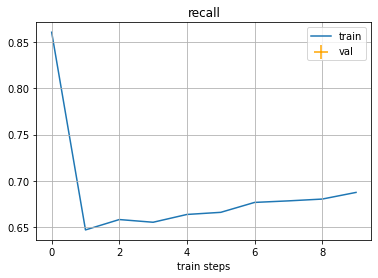

In [77]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

In [ ]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

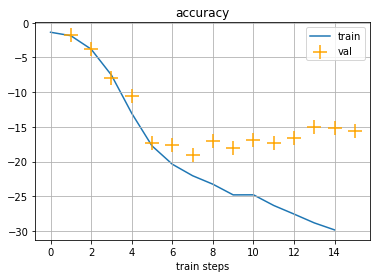

In [ ]:
# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")

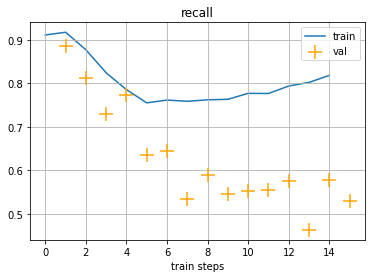

In [ ]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

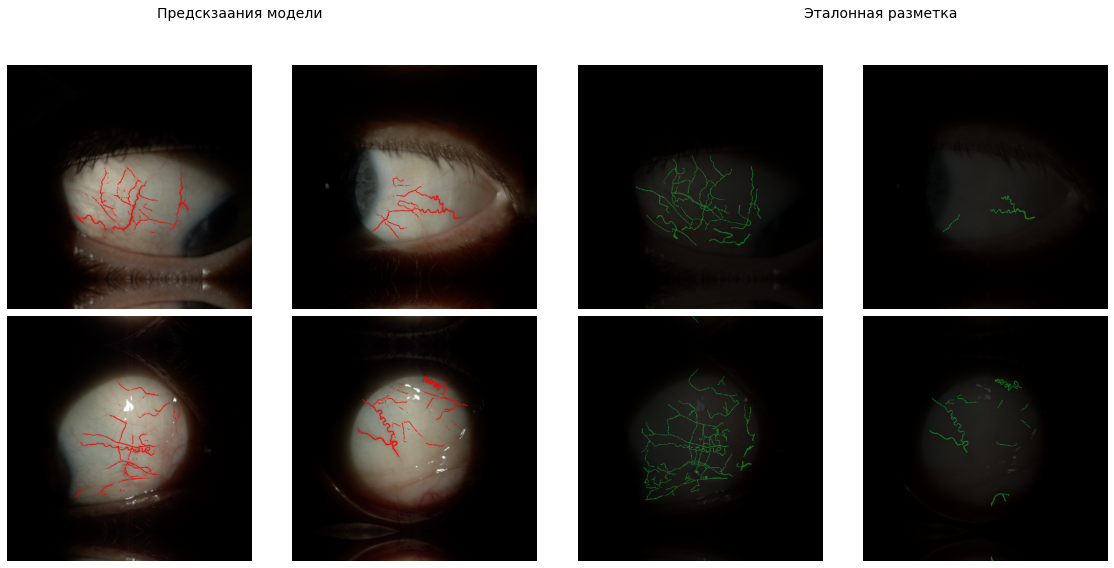

In [19]:
# Посмотрим на картинки предсказаний

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предскзаания модели {" "*105} Эталонная разметка', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to("cuda")
    true_mask = sample['mask'].to("cuda")

    prediction = model.eval()(image.unsqueeze(dim=0))

    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (1-(torch.exp(prediction[0]) > 0.5).cpu().int()).bool()

    image_with_mask = draw_segmentation_masks(image, pred_ask, alpha=1., colors=(255,0,0))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')


    image_with_mask = draw_segmentation_masks(image, true_mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image_with_mask)
    axs[i // 2, (i % 2)+2].axis('off')


fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [11]:
image.shape

torch.Size([3, 640, 640])